In [49]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict
import shutil
from tqdm import tqdm

In [57]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    print(xf, yf)
#         coords[:, 1] *= yf
#         coords[:, 0] *= xf
#         coords_int = np.round(coords).astype(np.int32)
#         return coords_int

def _convert_coordinates(geometry, img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax

    geometry_out = shapely.affinity.affine_transform(geometry, [xf,0,0,yf,0,0])
    return geometry_out
    
def _plot_mask_from_wkt(raster_img_size, geometry, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if geometry is None:
        return img_mask
    perim_list = []
    interior_list = []
    for k in range(len(geometry)):
        poly = geometry[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = np.round(perim).astype(np.int32)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = np.round(interior).astype(np.int32)
            interior_list.append(interior_c)
    
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask

def _get_xmax_ymin(self, grid_sizes_panda, imageId):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)


def _get_polygon_list(self, wkt_list_pandas, imageId, cType):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList


def _get_and_convert_contours(self, polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list


def _plot_mask_from_contours(self, raster_img_size, contours, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask


def _generate_mask_for_image_and_class(self, raster_size, imageId, class_type):#grid_sizes_panda=GS, wkt_list_pandas=DF):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    grid_sizes_panda = self.grid_sizes
    wkt_list_pandas = self.polygons
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)
    mask = _plot_mask_from_contours(raster_size, contours, 1)
    return mask

In [75]:
class MapObject (object):
    def __init__(self, img, polygons = None, poly_grids = None, mask = None, predicted_mask = None):
        '''Creates object that includes img (heigth, width, channels), poligons - dictionary {class:shapely MultipolygonWKT}, corresponding mask (heigth, width, num_classes)'''
        self.img = img
        self.polygons = polygons
        self.mask = mask
        self.predicted_mask = predicted_mask
        self.RGB_mask = None

    def _plot_mask_from_wkt(self, raster_img_size, geometry, class_value=1):
        # __author__ = visoft
        # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
        img_mask = np.zeros(raster_img_size, np.uint8)
        if geometry is None:
            return img_mask
        perim_list = []
        interior_list = []
        for k in range(len(geometry)):
            poly = geometry[k]
            perim = np.array(list(poly.exterior.coords))
            perim_c = np.round(perim).astype(np.int32)
            perim_list.append(perim_c)
            for pi in poly.interiors:
                interior = np.array(list(pi.coords))
                interior_c = np.round(interior).astype(np.int32)
                interior_list.append(interior_c)

        cv2.fillPoly(img_mask, perim_list, class_value)
        cv2.fillPoly(img_mask, interior_list, 0)
        return img_mask

    def poly2mask(self):
        mask_multi =[]
        _, h, w = img.shape
        for cls in list(self.polygons.keys()):
            mask = _plot_mask_from_wkt((h, w), self.polygons[cls])
            mask_multi.append(mask)
        mask_multi = np.array(mask_multi)
        self.mask = mask_multi
        return mask_multi
        
    def mask2poly():
        raise NotImplementedError
        
    def split():
        raise NotImplementedError
    
    def _augmentation():
        raise NotImplementedError
        
    def _crop():
        raise NotImplementedError
        
    def plot_RGB_mask():
        raise NotImplementedError
        
    
class DSTLDataset(object):
    def __init__(self):
        raise NotImplementedError
    
    def generate_patches():
        raise NotImplementedError
    
    def _form_dictionary_for_wkt_classes():
        mask_wkt = DF[DF.ImageId == img_id]
        mask_wkt = mask_wkt[mask_wkt.ClassType == 1]
        mask_wkt = mask_wkt.MultipolygonWKT.values[0]
        mask_raw = wkt_loads(mask_wkt)
        mask_raw = shapely.affinity.affine_transform(mask_raw, [xf,0,0,yf,0,0])

    

In [67]:
a = DSTLDataset()

TypeError: __init__() takes 0 positional arguments but 1 was given

In [ ]:
N_Cls = 10
inDir = 'Dataset/DSTL'
DF = pd.read_csv(inDir + '/train_wkt_v4.csv')
GS = pd.read_csv(inDir + '/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
SB = pd.read_csv(os.path.join(inDir, 'sample_submission.csv'))
img_id = '6140_1_2'

In [47]:
_convert_coordinates_to_raster(1, [H,W], [Xmax, Ymax])

370269.41808 -370243.395862


In [ ]:
masks_dict = {}
for cls in DF.ClassType.unique():
    mask_wkt = DF[DF.ImageId == img_id]
    mask_wkt = mask_wkt[mask_wkt.ClassType == cls]
    mask_wkt = mask_wkt.MultipolygonWKT.values[0]
    mask_raw = wkt_loads(mask_wkt)
    mask_raw = shapely.affinity.affine_transform(mask_raw, [xf,0,0,yf,0,0])
    masks_dict[cls] = mask_raw

print(list(mask_raw[0].exterior.coords))
print('\n')
mask_raw = shapely.affinity.affine_transform(mask_raw, [xf,0,0,yf,0,0])
print(list(mask_raw[0].exterior.coords))
mask_raw[0]
mask = _plot_mask_from_wkt([H,W], mask_raw)
plt.imshow(mask)
plt.show()
masks_dict

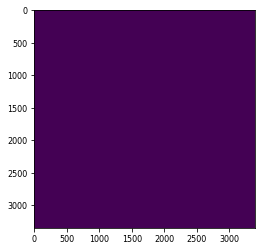

,ImageId,ClassType,MultipolygonWKT
148,6140_1_2,9,MULTIPOLYGON EMPTY


In [96]:
test = MapObject(img, masks_dict)
test.poly2mask()
plt.imshow(test.mask[8])
plt.show()

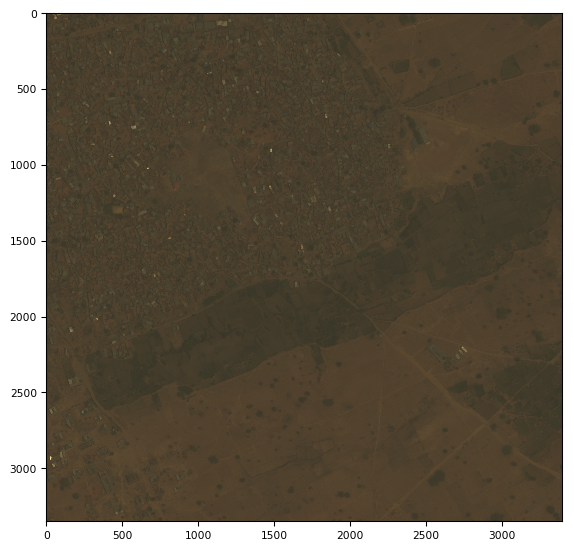

0.009169
-0.00904
370269.41808 -370243.395862


In [73]:
img = tiff.imread('Dataset/DSTL/three_band/6140_1_2.tif')
tiff.imshow(img)
plt.show()

_,H,W = img.shape
Xmax, Ymax = GS[GS.ImageId == img_id].iloc[0,1:3]
print(Xmax)
print(Ymax)
W1 = 1.0 * W * W / (W + 1)
H1 = 1.0 * H * H / (H + 1)
xf = W1 / Xmax
yf = H1 / Ymax
print(xf, yf)

In [70]:
a = {}
a[10] = 10
a['a'] = 'a'
a

{10: 10, 'a': 'a'}